In [2]:
import matplotlib.pylab as plt
import numpy as np
plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
%config InlineBackend.figure_format = 'svg'
import sys
import os
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

path_sav_fig = f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/eESAndpESDiscrimination/figure/"
if not os.path.isdir(path_sav_fig):
    os.mkdir(path_sav_fig)

key_Energy = "Erec"
key_tag = "evtType"
dir_map_tags = {0:"pES", 1:"eES"}

# Load Prediction Outputs
with np.load(f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/eESAndpESDiscrimination/predict_Combine.npz",
             allow_pickle=True) as f:
    dir_events = f["dir_events"].item()

# Erec_max = max( dir_events[key_Energy] )
Erec_max = 12.5
dir_diff_option_for_events = {"Without IBDp":dir_events}
print(dir_events[key_Energy])

[0.45743498 0.40903294 1.0430361  ... 0.18072918 0.37840062 0.38591179]


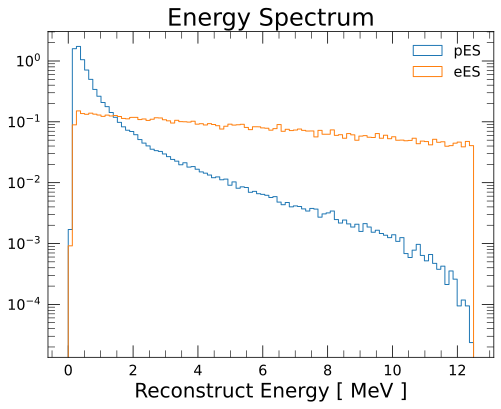

In [20]:
bins_equen= np.linspace(0, Erec_max ,100)
for tag in dir_map_tags.keys():
    plt.hist(dir_events[key_Energy][dir_events[key_tag]==tag],bins=bins_equen, histtype="step", label=dir_map_tags[tag],
             density=True)
plt.xlabel("Reconstruct Energy [ MeV ]")
plt.title("Energy Spectrum")
plt.semilogy()
plt.legend()
plt.savefig(path_sav_fig+"ebnergy_spectrum.png")


dict_keys(['evtID', 'h_time_without_charge', 'h_time_with_charge', 'XYZ', 'Erec', 'evtID_PSD', 'evtType', 'R3', 'PSD'])
dict_keys(['evtID', 'h_time_without_charge', 'h_time_with_charge', 'XYZ', 'Erec', 'evtID_PSD', 'evtType', 'R3', 'PSD'])
{'train': Counter({0: 20044, 1: 20044}), 'test': Counter({0: 335451, 1: 30067}), 'total': Counter({0: 355495, 1: 50111})}
PSD Cut: 0.512
Optimized  Efficiency:
 pES inefficiency:	 1.000 % +- 0.017 
eES efficiency:	 96.790 % +- 0.1

Optimized  Ratio of Residue:
 pES Ratio:	 6.829 % +- 0.11 
eES Ratio:	 93.171 % +- 0.11

##############################################

?????????????????? None


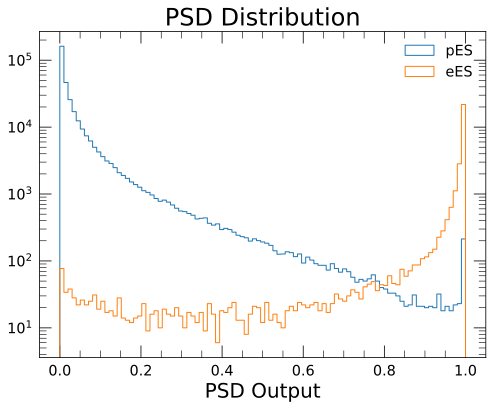

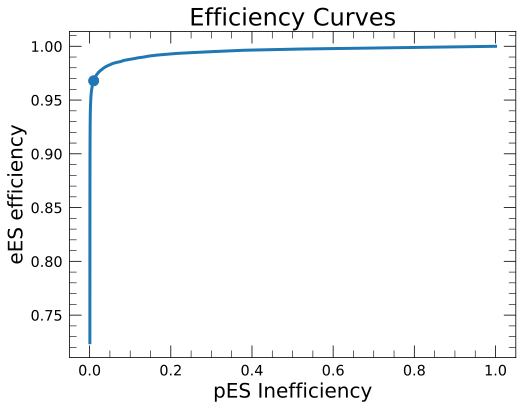

In [51]:
from importlib import reload
import DiscriminationTools
reload(DiscriminationTools)
from DiscriminationTools import  DiscriminationTools
discrimination_tool = DiscriminationTools(key_0="pES", key_1="eES")

print(dir_events.keys())

discrimination_tool.GetPredictionData("/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/eESAndpESDiscrimination/predict_Combine.npz")
discrimination_tool.GetPSDDistribution()
discrimination_tool.PlotROCCurves()
discrimination_tool.MaximumSignificance(v_bkg_ineff=np.linspace(0.01, 0.2,1000), condition="Total Samples", set_global_PSD_cut=True)




PSD Cut: 0.237
Optimized  Efficiency:
 pES inefficiency:	 3.466 % +- 0.032 
eES efficiency:	 73.332 % +- 0.26

Optimized  Ratio of Residue:
 pES Ratio:	 25.113 % +- 0.2 
eES Ratio:	 74.887 % +- 0.2

##############################################

PSD Cut: 0.512
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.894 % +- 0.016 
eES efficiency:	 56.116 % +- 0.29

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 10.156 % +- 0.17 
eES Ratio:	 89.844 % +- 0.17

##############################################

PSD Cut: 0.4
Optimized  Efficiency:
 pES inefficiency:	 1.594 % +- 0.022 
eES efficiency:	 86.510 % +- 0.2

Optimized  Ratio of Residue:
 pES Ratio:	 11.560 % +- 0.14 
eES Ratio:	 88.440 % +- 0.14

##############################################

PSD Cut: 0.512
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.892 % +- 0.016 
eES efficiency:	 82.008 % +- 0.22

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 7.160 % +- 0.12 
eES Ratio:	 92.840 % +- 0.12

##################################

No handles with labels found to put in legend.


PSD Cut: 0.59
Optimized  Efficiency:
 pES inefficiency:	 0.339 % +- 0.01 
eES efficiency:	 98.384 % +- 0.073

Optimized  Ratio of Residue:
 pES Ratio:	 2.386 % +- 0.068 
eES Ratio:	 97.614 % +- 0.068

##############################################

PSD Cut: 0.512
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.514 % +- 0.012 
eES efficiency:	 98.845 % +- 0.062

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 3.559 % +- 0.082 
eES Ratio:	 96.441 % +- 0.082

##############################################

PSD Cut: 0.633
Optimized  Efficiency:
 pES inefficiency:	 0.299 % +- 0.0094 
eES efficiency:	 98.496 % +- 0.07

Optimized  Ratio of Residue:
 pES Ratio:	 2.110 % +- 0.064 
eES Ratio:	 97.890 % +- 0.064

##############################################

PSD Cut: 0.512
Certain PSD Cut  Efficiency:
 pES inefficiency:	 0.802 % +- 0.015 
eES efficiency:	 99.050 % +- 0.056

Certain PSD Cut  Ratio of Residue:
 pES Ratio:	 5.432 % +- 0.099 
eES Ratio:	 94.568 % +- 0.099

######################

,index,eES Eff.,pES Ineff.,(eES Residue)/(Total Residue),(pES Residue)/(Total Residue),PSD Cut
0,Total Samples,96.790 % +- 0.1,1.000 % +- 0.017,93.171 % +- 0.11,6.829 % +- 0.11,0.51
1,0.20 < $E_{rec}$ < 0.51 MeV,73.332 % +- 0.26,3.466 % +- 0.032,74.887 % +- 0.2,25.113 % +- 0.2,0.24
2,0.20 < $E_{rec}$ < 0.51 MeV(Global Cut),56.116 % +- 0.29,0.894 % +- 0.016,89.844 % +- 0.17,10.156 % +- 0.17,0.51
3,0.51 < $E_{rec}$ < 0.82 MeV,86.510 % +- 0.2,1.594 % +- 0.022,88.440 % +- 0.14,11.560 % +- 0.14,0.4
4,0.51 < $E_{rec}$ < 0.82 MeV(Global Cut),82.008 % +- 0.22,0.892 % +- 0.016,92.840 % +- 0.12,7.160 % +- 0.12,0.51
5,0.82 < $E_{rec}$ < 1.13 MeV,92.444 % +- 0.15,0.598 % +- 0.013,95.612 % +- 0.093,4.388 % +- 0.093,0.51
6,0.82 < $E_{rec}$ < 1.13 MeV(Global Cut),92.357 % +- 0.15,0.583 % +- 0.013,95.717 % +- 0.092,4.283 % +- 0.092,0.51
7,1.13 < $E_{rec}$ < 1.44 MeV,94.486 % +- 0.13,0.439 % +- 0.011,96.812 % +- 0.079,3.188 % +- 0.079,0.57
8,1.13 < $E_{rec}$ < 1.44 MeV(Global Cut),95.496 % +- 0.12,0.650 % +- 0.014,95.396 % +- 0.094,4.604 % +- 0.094,0.51
9,1.44 < $E_{rec}$ < 1.76 MeV,98.384 % +- 0.073,0.339 % +- 0.01,97.614 % +- 0.068,2.386 % +- 0.068,0.59


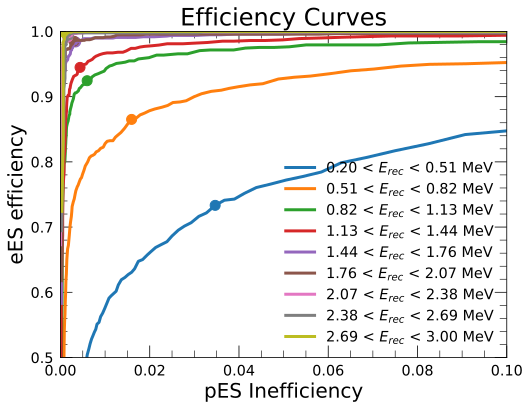

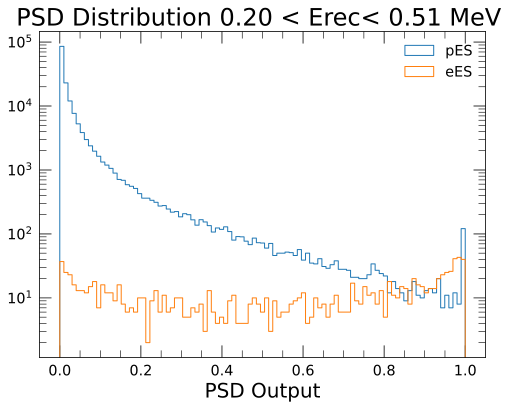

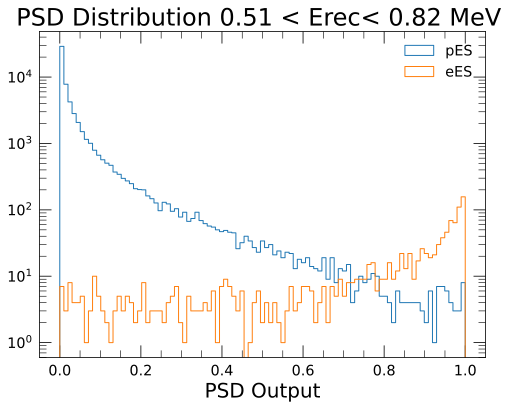

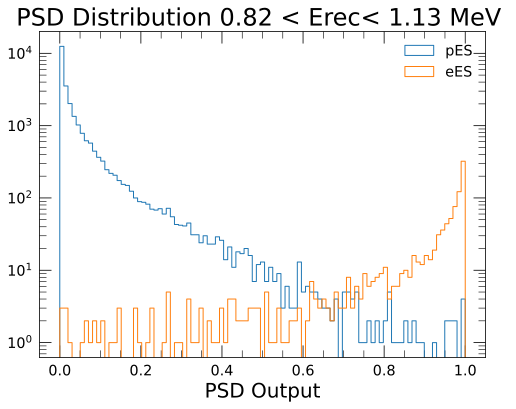

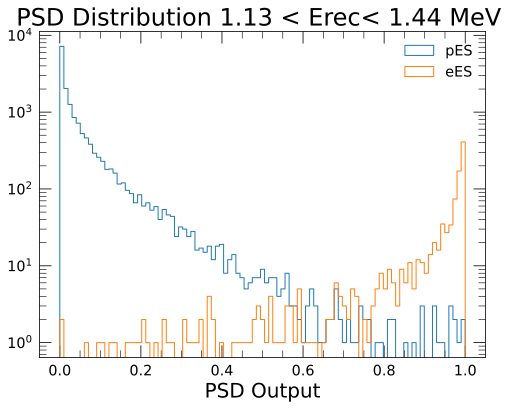

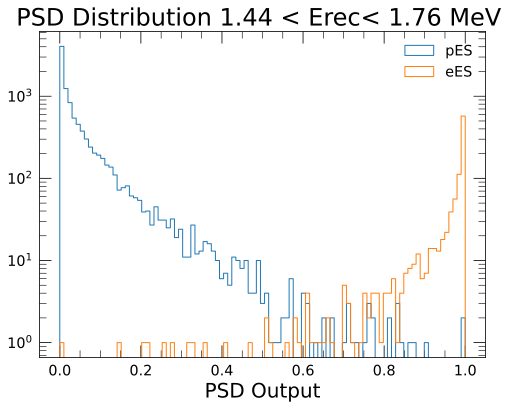

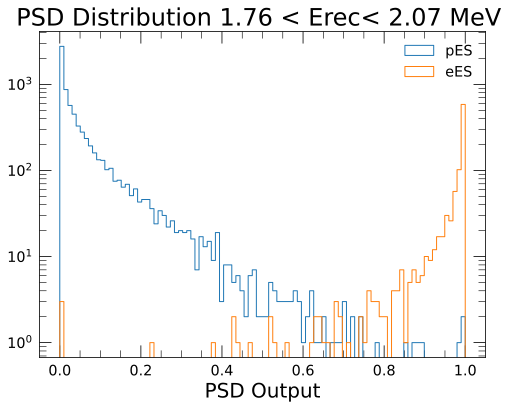

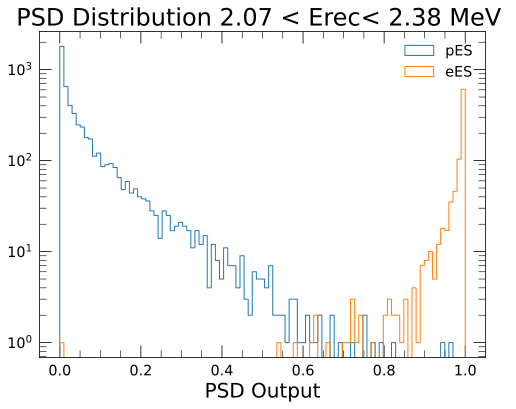

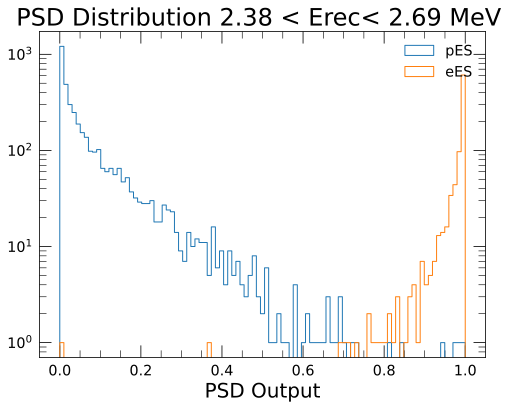

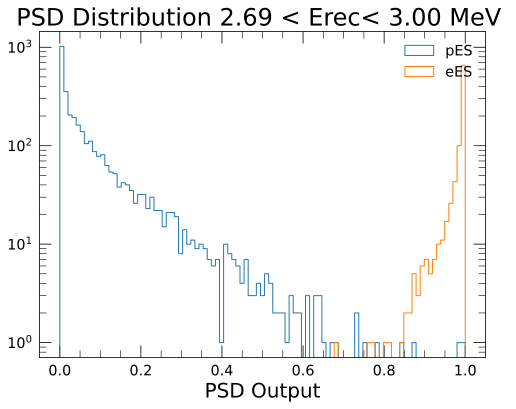

In [52]:
discrimination_tool.PlotROCCurvesDiffEBins(bins_Energy=np.linspace(0.2, 3, 10), xlim=(0, 0.1), ylim=(0.5,1),
                                           v_bkg_ineff=np.linspace(0.001, 0.2,1000))
discrimination_tool.PrintEffDataframe()